# 추천 시스템 - 아이템 기반 협업 필터링(Item Based Collaborative Filtering) & 잠재요인 협업필터링 (Latent Factor Collaborative Filtering) - Matrix Factorization
 - 앱의 리뷰정보와 개발자Q&A답변을 기반으로 설치한 앱과 유사한 앱을 추천
 - 가중평점으로 정렬해서 높은 것부터 노출 시킴
 - 앱의 리뷰정보를 기반으로 사용자가 설치한 앱과 유사한 앱 10개 추천 (아이템5개 + 잠재요인5개)
 - 개발자 Q&A답변을 기반으로 사용자가 설치한 앱과 유사한 앱 10개 추천 (아이템5개 + 잠재요인5개)
 - 데이터는 kaggle의 https://www.kaggle.com/usernam3/shopify-app-store 를 전처리한 데이터입니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import time
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
app_df = pd.read_csv('./temp_data/app_df.csv',delimiter = None,encoding='utf-8')
print(app_df.shape)
print(app_df.info())
app_df.head()

(4750, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   app_id           4750 non-null   object 
 1   title            4750 non-null   object 
 2   rating           4750 non-null   float64
 3   reviews_count    4750 non-null   int64  
 4   app_description  4750 non-null   object 
 5   tagline          4750 non-null   object 
 6   categories       4750 non-null   object 
 7   dev_answer       4309 non-null   object 
 8   review           3733 non-null   object 
 9   wr_rating        4750 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 371.2+ KB
None


,app_id,title,rating,reviews_count,app_description,tagline,categories,dev_answer,review,wr_rating
0,9e4748a9-7eda-4814-83b6-0537d44152b1,Panda Language Translate,4.7,379,['Panda Language Translation improve your busi...,Translate your store into multiple languages,10,"increase,sales,global,help,visitors,increase,s...","thank,pretty,helpful,simplicity,love,helpful",30.800631
1,d1476138-a608-4bb9-8d39-b30f3ca7617d,Instant Brand Page,4.9,13,['Having a brand page gives your shoppers a qu...,A-Z Brand Index Page and Favourites Slider,10,"layout,customise,ease,pages,individual,brand,s...","responsive,friendly,helpful,sale,easy,automati...",87.308207
2,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,FAQ Accordion | Help Center,4.5,202,"['Create, organize and display Frequently Aske...","FAQ page, FAQ accordion menu for product Info ...","10,0","custom,popular,accordion,frequently,refund,cus...","recommend,free,satisfying,lost,poor,bugs",43.588712
3,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,Promote Me | Many apps in one,4.9,18,['Promote Me app is a bundle of apps that incl...,"Spin Wheel,Currency Converter,Quick ATC Button...","10,9","button,fortune,checkout,redirect,button,autoco...","app,apps,customizable,easy,makeprosimp,apps",84.941515
4,7aac2a1f-ff03-4f38-aeb7-7619403a6f05,Instalify,0.0,0,['We are trusted by hundreds of Shopify and Sh...,Supercharge Your Mobile App Installs,10,"websites,app,download,simple,quick,minutes,app...",NaN,94.171158


# 1. 개발자 답변을 기반으로 추천

### 아이템 기반 협업 필터링을 위한 개발자 답변 키워드 벡터화
- 아이템 기반 협업 필터링이므로 row가 user 기반이면 안되고, item이 row가 되어야 함 
- 왜냐하면 cosine similarity를 구할 때 row 기반으로 유사도를 측정하기 때문

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
answer_df = app_df[['app_id','dev_answer']]
answer_df.fillna('', inplace=True)
answer_df

,app_id,dev_answer
0,9e4748a9-7eda-4814-83b6-0537d44152b1,"increase,sales,global,help,visitors,increase,s..."
1,d1476138-a608-4bb9-8d39-b30f3ca7617d,"layout,customise,ease,pages,individual,brand,s..."
2,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,"custom,popular,accordion,frequently,refund,cus..."
3,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,"button,fortune,checkout,redirect,button,autoco..."
4,7aac2a1f-ff03-4f38-aeb7-7619403a6f05,"websites,app,download,simple,quick,minutes,app..."
...,...,...
4745,a2197ba7-c0d0-4954-9b37-09c7f27ec919,"inquiries,cart,button,product,custom,customers..."
4746,28cd2f9d-61ea-447f-ae7d-e67440352d19,"textbox,upload,unlimited,customers,decorating,..."
4747,f6fc54ce-9999-4180-8e7e-c899bbf30bbd,"customer,increase,sales,built,forms,templates,..."
4748,95d883a8-7dba-443d-a6ee-f018d4446985,"color,product,shopify,swatch,themes,choose,ins..."


In [5]:
tfidf_vector = TfidfVectorizer()

answer_matrix = tfidf_vector.fit_transform(np.array(answer_df['dev_answer'])).toarray()

answer_matrix_feature = tfidf_vector.get_feature_names()

answer_matrix_df = pd.DataFrame(answer_matrix, columns=answer_matrix_feature, index=app_df.app_id)

# 영어가 아닌 것들 제외
answer_matrix_df = answer_matrix_df.iloc[:,112:4284]

print(answer_matrix_df.shape)
answer_matrix_df

(4750, 4172)


,abandon,abandonados,abandoned,abandoners,abandoning,abandonment,abandonments,abandons,abarcamos,abc,...,zigzag,zip,zipcode,zipcodes,ziphub,ziplink,ziplinks,zoom,zoomed,zoorix
app_id,,,,,,,,,,,,,,,,,,,,,
9e4748a9-7eda-4814-83b6-0537d44152b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d1476138-a608-4bb9-8d39-b30f3ca7617d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0ef0087f-3ae5-4dbc-84e0-193b576d82ed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7aac2a1f-ff03-4f38-aeb7-7619403a6f05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a2197ba7-c0d0-4954-9b37-09c7f27ec919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28cd2f9d-61ea-447f-ae7d-e67440352d19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f6fc54ce-9999-4180-8e7e-c899bbf30bbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### cosine similarity를 이용해 item별로 유사한 것을 측정

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
answer_matrix_df_collabor = cosine_similarity(answer_matrix_df)
answer_matrix_df_collabor

array([[1.        , 0.        , 0.        , ..., 0.12483996, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.0726183 , 0.        ,
        0.10098562],
       ...,
       [0.12483996, 0.        , 0.0726183 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.10098562, ..., 0.        , 0.        ,
        1.        ]])

- cosine similarity로 구한 유사도 점수를 컬럼을 매칭하여 데이터 프레임으로 변환

In [8]:
answer_sim_df = pd.DataFrame(data=answer_matrix_df_collabor, index=answer_matrix_df.index, columns=answer_matrix_df.index)
answer_sim_df

app_id,9e4748a9-7eda-4814-83b6-0537d44152b1,d1476138-a608-4bb9-8d39-b30f3ca7617d,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,7aac2a1f-ff03-4f38-aeb7-7619403a6f05,c13bfb7f-8b5a-40c6-a338-dbdec5cfd130,6a71634f-f94f-498d-8713-d2b01ca90917,da50f0bf-d116-46a0-b0c1-0d90c05d8ffe,89735c3c-4d25-40f2-8b54-150f59cfb099,3c89c108-4858-4b07-893a-460ea5a0d91a,...,be55ff9a-fad0-4b04-ac9c-49b7f8d99040,20c5a19d-a8e2-4fd2-8c80-97df27b08bd5,c9a821be-7f7a-4adc-8c77-cd61a03d4762,1d5259bf-b0e2-4850-a11f-6890a2c9c189,fb7ec3a7-7bde-4f87-82cd-d68ab4b41961,a2197ba7-c0d0-4954-9b37-09c7f27ec919,28cd2f9d-61ea-447f-ae7d-e67440352d19,f6fc54ce-9999-4180-8e7e-c899bbf30bbd,95d883a8-7dba-443d-a6ee-f018d4446985,17918ea4-80b9-4811-947d-c0b2f950976a
app_id,,,,,,,,,,,,,,,,,,,,,
9e4748a9-7eda-4814-83b6-0537d44152b1,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.027548,0.000000,0.126270,0.000000,0.000000,0.000000,0.028154,0.124840,0.000000,0.000000
d1476138-a608-4bb9-8d39-b30f3ca7617d,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.023209,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.015860,0.078933,0.000000,0.000000,0.102949,0.014354,0.072618,0.000000,0.100986
0ef0087f-3ae5-4dbc-84e0-193b576d82ed,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.057672,0.000000,0.000000,0.171165,0.352812,0.000000,0.000000,0.000000,0.000000
7aac2a1f-ff03-4f38-aeb7-7619403a6f05,0.000000,0.0,0.000000,0.000000,1.0,0.100156,0.000000,0.000000,0.061668,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a2197ba7-c0d0-4954-9b37-09c7f27ec919,0.000000,0.0,0.102949,0.352812,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.035242,0.000000,0.054424,0.000000,1.000000,0.031897,0.080684,0.056351,0.114084
28cd2f9d-61ea-447f-ae7d-e67440352d19,0.028154,0.0,0.014354,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.066882,...,0.026454,0.017441,0.000000,0.114513,0.099266,0.031897,1.000000,0.026826,0.000000,0.045658
f6fc54ce-9999-4180-8e7e-c899bbf30bbd,0.124840,0.0,0.072618,0.000000,0.0,0.000000,0.000000,0.118018,0.000000,0.000000,...,0.054643,0.000000,0.000000,0.000000,0.000000,0.080684,0.026826,1.000000,0.000000,0.000000


### 현재 사용자가 설치한(리뷰한) 앱과 유사한 앱 추출
 - 자기자신을 제외한 유사도가 높은 상위 10개 앱

In [9]:
nowApp = 'b1da53a4-0474-4700-9620-bf386bc033fb'
recommend_list = answer_sim_df[nowApp].sort_values(ascending=False)[1:11]
recommend_list

app_id
1b7e8701-e1e3-45a4-adf3-981ced6f1f67    0.338747
0ec41a8a-a698-4b59-942d-1c4f4fbd1d66    0.186927
c02e806c-7770-48f7-9d92-d34ab68a2a51    0.176391
ecbc7b6f-55a6-4b0b-b733-10f07ea589ae    0.174495
9d974199-4d4f-4fbf-b6ba-67e3a2fa3a17    0.173943
3a8867af-7108-4284-9e4b-6d9fe5faf397    0.172347
a576c419-d020-42a3-b361-dd32e26f1341    0.166815
01abd423-ae67-4e00-a82a-fd7b490b10d6    0.162657
5b8b2677-81b9-42ff-8de4-807819b3e184    0.161080
d55d593e-a22f-416b-b4cc-ac315459ed73    0.158197
Name: b1da53a4-0474-4700-9620-bf386bc033fb, dtype: float64

- 추출한 10개 앱에 가중평점을 맵핑해서 정렬 후 상위 5개 앱 추출

In [10]:
wr_rating = pd.merge(left=recommend_list.to_frame(), right=app_df[['app_id','wr_rating']], how='left', on='app_id')
recommend_answer = wr_rating.sort_values(by='wr_rating', ascending=False).iloc[:5,:]
recommend_answer

,app_id,b1da53a4-0474-4700-9620-bf386bc033fb,wr_rating
6,a576c419-d020-42a3-b361-dd32e26f1341,0.166815,94.171158
3,ecbc7b6f-55a6-4b0b-b733-10f07ea589ae,0.174495,93.603550
4,9d974199-4d4f-4fbf-b6ba-67e3a2fa3a17,0.173943,90.833546
8,5b8b2677-81b9-42ff-8de4-807819b3e184,0.161080,85.825205
9,d55d593e-a22f-416b-b4cc-ac315459ed73,0.158197,75.798663


### 잠재 기반 협업 필터링을 위한 개발자 답변 벡터화
 - 위에서 벡터화한 데이터 그대로 사용

In [11]:
answer_matrix_df

,abandon,abandonados,abandoned,abandoners,abandoning,abandonment,abandonments,abandons,abarcamos,abc,...,zigzag,zip,zipcode,zipcodes,ziphub,ziplink,ziplinks,zoom,zoomed,zoorix
app_id,,,,,,,,,,,,,,,,,,,,,
9e4748a9-7eda-4814-83b6-0537d44152b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d1476138-a608-4bb9-8d39-b30f3ca7617d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0ef0087f-3ae5-4dbc-84e0-193b576d82ed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7aac2a1f-ff03-4f38-aeb7-7619403a6f05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a2197ba7-c0d0-4954-9b37-09c7f27ec919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28cd2f9d-61ea-447f-ae7d-e67440352d19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f6fc54ce-9999-4180-8e7e-c899bbf30bbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 특이값 분해 SVD(Singular Value Decomposion)
- truncated SVD는 시그마 행렬의 대각원소(특이값) 가운데 상위 n개만 골라낸 것이다.
- 이렇게 하면 기존 행렬 A의 성질을 100% 복원할 수는 없지만, (그 만큼 데이터 정보를 압축) 기존 행렬과 거의 근사한 값이 나오게 된다.

In [12]:
from sklearn.decomposition import TruncatedSVD

- 12개의 component로 차원을 축소
- 이렇게 하면 전체의 앱들이 어떤 12개의 요소의 값을 가지게 됨

In [13]:
svd = TruncatedSVD(n_components=12, random_state=42)
matrix_answer = svd.fit_transform(answer_matrix_df)

print(matrix_answer[0])
print(matrix_answer.shape)

[ 0.16648542 -0.04377958  0.14742457  0.26830337  0.02835864  0.00395533
 -0.01481008 -0.01458268 -0.00736349 -0.08279988  0.0572787   0.18650656]
(4750, 12)


- 이렇게 나온 데이터를 활용해서 피어슨 상관계수를 구함

In [14]:
corr = np.corrcoef(matrix_answer)
corr.shape

(4750, 4750)

- 그래프를 그리기 위해 200개만 추출

<AxesSubplot:>

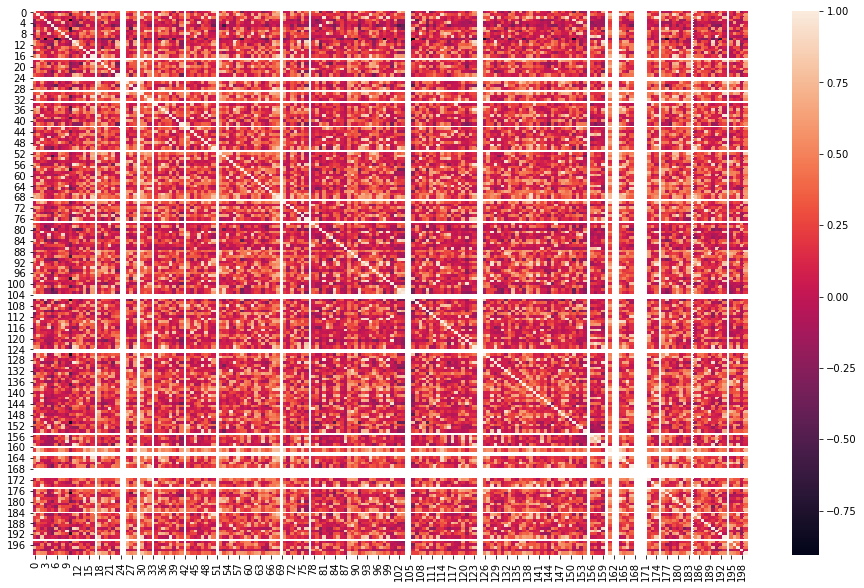

In [15]:
corr2 = corr[:200, :200]
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

### 위에서 구한 상관계수를 이용해서 특정 앱과 상관계수가 높은 앱 상위 5개를 추출함

In [16]:
app_title = answer_matrix_df.index
app_title_list = list(app_title) # 앱 전체 목록
coffey_hands = app_title_list.index(nowApp) # 해당 앱의 인덱스
coffey_hands

3066

In [17]:
corr_coffey_hands = corr[coffey_hands] # 특정 앱과 다른 앱들의 상관계수를 추출
coffey_hands_df = pd.DataFrame(data=corr_coffey_hands, index=app_title, columns=['corr']) # 앱과 상관계수를 맵핑
recommend = coffey_hands_df.loc[coffey_hands_df['corr'] >= 0.9]  # 상관계수가 0.9 이상인 영화를 추출
recommend_latent_answer = recommend.sort_values(by='corr', ascending=False)[1:6] # 상관계수로 정렬 후 상위 5개 앱만 추출
recommend_latent_answer

,corr
app_id,
feb77662-2bcc-4038-91dc-1c96c7baf0f1,0.962915
a4e16cca-2a0f-44a7-8348-0477cdf3b417,0.952583
4595c60e-b4f9-4f45-9a75-b53e4bc7976a,0.922053
5c807510-979b-4f2d-8120-87f8ac352e95,0.917189
72ebe6d8-1174-4f74-a96c-e3b924a59675,0.913579


### 아이템으로 추천된 5개 앱과 잠재요인으로 추천된 앱 5개를 합쳐서 사용자에게 총 10개의 앱을 추천

In [18]:
result_answer = pd.concat([recommend_answer, recommend_latent_answer.reset_index()], axis=0).reset_index(drop=True)
result_answer['app_id']

0    a576c419-d020-42a3-b361-dd32e26f1341
1    ecbc7b6f-55a6-4b0b-b733-10f07ea589ae
2    9d974199-4d4f-4fbf-b6ba-67e3a2fa3a17
3    5b8b2677-81b9-42ff-8de4-807819b3e184
4    d55d593e-a22f-416b-b4cc-ac315459ed73
5    feb77662-2bcc-4038-91dc-1c96c7baf0f1
6    a4e16cca-2a0f-44a7-8348-0477cdf3b417
7    4595c60e-b4f9-4f45-9a75-b53e4bc7976a
8    5c807510-979b-4f2d-8120-87f8ac352e95
9    72ebe6d8-1174-4f74-a96c-e3b924a59675
Name: app_id, dtype: object

# 2. 앱 리뷰들을 기반으로 추천

### 아이템 기반 협업 필터링을 위한 리뷰 키워드 벡터화
- 아이템 기반 협업 필터링이므로 row가 user 기반이면 안되고, item이 row가 되어야 함 
- 왜냐하면 cosine similarity를 구할 때 row 기반으로 유사도를 측정하기 때문

In [19]:
review_df = app_df[['app_id','review']]
review_df.fillna('', inplace=True)
review_df

,app_id,review
0,9e4748a9-7eda-4814-83b6-0537d44152b1,"thank,pretty,helpful,simplicity,love,helpful"
1,d1476138-a608-4bb9-8d39-b30f3ca7617d,"responsive,friendly,helpful,sale,easy,automati..."
2,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,"recommend,free,satisfying,lost,poor,bugs"
3,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,"app,apps,customizable,easy,makeprosimp,apps"
4,7aac2a1f-ff03-4f38-aeb7-7619403a6f05,
...,...,...
4745,a2197ba7-c0d0-4954-9b37-09c7f27ec919,"thediamonddaughters,customize,jewelry,website,..."
4746,28cd2f9d-61ea-447f-ae7d-e67440352d19,"app,apps,easy,value,good,easy"
4747,f6fc54ce-9999-4180-8e7e-c899bbf30bbd,"wow,nice,love,developer,bash,bashing"
4748,95d883a8-7dba-443d-a6ee-f018d4446985,"webyze,customizing,happy,outstanding,website,app"


In [20]:
tfidf_vector = TfidfVectorizer()

review_matrix = tfidf_vector.fit_transform(np.array(review_df['review'])).toarray()

review_matrix_feature = tfidf_vector.get_feature_names()

review_matrix_df = pd.DataFrame(review_matrix, columns=review_matrix_feature, index=app_df.app_id)

# 영어가 아닌 것들 제외
review_matrix_df = review_matrix_df.iloc[:,95:3159]

print(review_matrix_df.shape)
review_matrix_df

(4750, 3064)


,abandon,abandoned,abandonment,ability,able,abschließenden,absolute,absurd,abusive,accessories,...,zendesk,zenquiries,zenstores,zenzejnqszfjt3pckwt5,zero,zijn,zipcode,zonder,zoo,zooomy
app_id,,,,,,,,,,,,,,,,,,,,,
9e4748a9-7eda-4814-83b6-0537d44152b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d1476138-a608-4bb9-8d39-b30f3ca7617d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0ef0087f-3ae5-4dbc-84e0-193b576d82ed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7aac2a1f-ff03-4f38-aeb7-7619403a6f05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a2197ba7-c0d0-4954-9b37-09c7f27ec919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28cd2f9d-61ea-447f-ae7d-e67440352d19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f6fc54ce-9999-4180-8e7e-c899bbf30bbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### cosine similarity를 이용해 item별로 유사한 것을 측정

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
review_matrix_df_collabor = cosine_similarity(review_matrix_df)
review_matrix_df_collabor

array([[1.        , 0.13979726, 0.        , ..., 0.06686364, 0.        ,
        0.13461249],
       [0.13979726, 1.        , 0.        , ..., 0.        , 0.        ,
        0.07231873],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06686364, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.02619097],
       [0.13461249, 0.07231873, 0.        , ..., 0.        , 0.02619097,
        1.        ]])

- cosine similarity로 구한 유사도 점수를 컬럼을 매칭하여 데이터 프레임으로 변환

In [23]:
review_sim_df = pd.DataFrame(data=review_matrix_df_collabor, index=review_matrix_df.index, columns=review_matrix_df.index)
review_sim_df

app_id,9e4748a9-7eda-4814-83b6-0537d44152b1,d1476138-a608-4bb9-8d39-b30f3ca7617d,d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0ef0087f-3ae5-4dbc-84e0-193b576d82ed,7aac2a1f-ff03-4f38-aeb7-7619403a6f05,c13bfb7f-8b5a-40c6-a338-dbdec5cfd130,6a71634f-f94f-498d-8713-d2b01ca90917,da50f0bf-d116-46a0-b0c1-0d90c05d8ffe,89735c3c-4d25-40f2-8b54-150f59cfb099,3c89c108-4858-4b07-893a-460ea5a0d91a,...,be55ff9a-fad0-4b04-ac9c-49b7f8d99040,20c5a19d-a8e2-4fd2-8c80-97df27b08bd5,c9a821be-7f7a-4adc-8c77-cd61a03d4762,1d5259bf-b0e2-4850-a11f-6890a2c9c189,fb7ec3a7-7bde-4f87-82cd-d68ab4b41961,a2197ba7-c0d0-4954-9b37-09c7f27ec919,28cd2f9d-61ea-447f-ae7d-e67440352d19,f6fc54ce-9999-4180-8e7e-c899bbf30bbd,95d883a8-7dba-443d-a6ee-f018d4446985,17918ea4-80b9-4811-947d-c0b2f950976a
app_id,,,,,,,,,,,,,,,,,,,,,
9e4748a9-7eda-4814-83b6-0537d44152b1,1.000000,0.139797,0.0,0.000000,0.0,0.152715,0.0,0.000000,0.000000,0.152584,...,0.083568,0.000000,0.000000,0.209477,0.080446,0.000000,0.000000,0.066864,0.000000,0.134612
d1476138-a608-4bb9-8d39-b30f3ca7617d,0.139797,1.000000,0.0,0.054705,0.0,0.078193,0.0,0.000000,0.000000,0.081973,...,0.000000,0.000000,0.000000,0.190577,0.000000,0.000000,0.114375,0.000000,0.000000,0.072319
d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0ef0087f-3ae5-4dbc-84e0-193b576d82ed,0.000000,0.054705,0.0,1.000000,0.0,0.000000,0.0,0.021370,0.023132,0.144961,...,0.000000,0.043186,0.127174,0.338265,0.000000,0.158318,0.288429,0.000000,0.019812,0.099518
7aac2a1f-ff03-4f38-aeb7-7619403a6f05,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a2197ba7-c0d0-4954-9b37-09c7f27ec919,0.000000,0.000000,0.0,0.158318,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.116232,0.000000,1.000000,0.000000,0.000000,0.070449,0.000000
28cd2f9d-61ea-447f-ae7d-e67440352d19,0.000000,0.114375,0.0,0.288429,0.0,0.000000,0.0,0.022340,0.024182,0.235846,...,0.000000,0.045146,0.066473,0.322431,0.000000,0.000000,1.000000,0.000000,0.020711,0.178410
f6fc54ce-9999-4180-8e7e-c899bbf30bbd,0.066864,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


### 현재 사용자가 설치한(리뷰한) 앱과 유사한 앱 추출
 - 자기자신을 제외한 유사도가 높은 상위 10개 앱

In [24]:
nowApp = 'b1da53a4-0474-4700-9620-bf386bc033fb'
recommend_list = review_sim_df[nowApp].sort_values(ascending=False)[1:11]
recommend_list

app_id
8df5cb8a-cb70-4d35-a538-e689694bfdb0    0.382994
ea83d01d-8b24-46a6-a183-76a71bbeebd6    0.380177
09f67746-a0aa-4bce-a59f-01a896271a75    0.333004
cfae7502-a7ab-46de-ab94-7f64e8e06f31    0.327086
18e1caa4-3513-4962-a69b-7f5768fc697f    0.316038
3ee7c943-b0a1-41c1-899a-40426a6e11f4    0.299329
47dba6dd-a5e3-4db8-9379-9807dd79f146    0.282900
bbd74706-7c31-4d8b-8d41-5f4c23a7b8a2    0.264158
5d49dbf4-11b1-421b-a9b0-7149394ccf26    0.254918
1aeb506e-1dc0-42c9-acb1-b3ecbc22e2fb    0.249104
Name: b1da53a4-0474-4700-9620-bf386bc033fb, dtype: float64

- 추출한 10개 앱에 가중평점을 맵핑해서 정렬 후 상위 5개 앱 추출

In [25]:
wr_rating = pd.merge(left=recommend_list.to_frame(), right=app_df[['app_id','wr_rating']], how='left', on='app_id')
recommend_review = wr_rating.sort_values(by='wr_rating', ascending=False).iloc[:5,:]
recommend_review

,app_id,b1da53a4-0474-4700-9620-bf386bc033fb,wr_rating
2,09f67746-a0aa-4bce-a59f-01a896271a75,0.333004,93.043123
0,8df5cb8a-cb70-4d35-a538-e689694bfdb0,0.382994,93.030473
5,3ee7c943-b0a1-41c1-899a-40426a6e11f4,0.299329,92.997582
4,18e1caa4-3513-4962-a69b-7f5768fc697f,0.316038,90.870560
3,cfae7502-a7ab-46de-ab94-7f64e8e06f31,0.327086,90.271108


### 잠재 기반 협업 필터링을 위한 개발자 답변 벡터화
 - 위에서 벡터화한 데이터 그대로 사용

In [26]:
review_matrix_df

,abandon,abandoned,abandonment,ability,able,abschließenden,absolute,absurd,abusive,accessories,...,zendesk,zenquiries,zenstores,zenzejnqszfjt3pckwt5,zero,zijn,zipcode,zonder,zoo,zooomy
app_id,,,,,,,,,,,,,,,,,,,,,
9e4748a9-7eda-4814-83b6-0537d44152b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d1476138-a608-4bb9-8d39-b30f3ca7617d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d6e49a3c-2f9f-4bfa-8c26-5d024faf2241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0ef0087f-3ae5-4dbc-84e0-193b576d82ed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7aac2a1f-ff03-4f38-aeb7-7619403a6f05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a2197ba7-c0d0-4954-9b37-09c7f27ec919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28cd2f9d-61ea-447f-ae7d-e67440352d19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f6fc54ce-9999-4180-8e7e-c899bbf30bbd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 특이값 분해 SVD(Singular Value Decomposion)
- truncated SVD는 시그마 행렬의 대각원소(특이값) 가운데 상위 n개만 골라낸 것이다.
- 이렇게 하면 기존 행렬 A의 성질을 100% 복원할 수는 없지만, (그 만큼 데이터 정보를 압축) 기존 행렬과 거의 근사한 값이 나오게 된다.

In [27]:
from sklearn.decomposition import TruncatedSVD

- 12개의 component로 차원을 축소
- 이렇게 하면 전체의 앱들이 어떤 12개의 요소의 값을 가지게 됨

In [28]:
svd = TruncatedSVD(n_components=12, random_state=42)
matrix_review = svd.fit_transform(review_matrix_df)

print(matrix_review[0])
print(matrix_review.shape)

[ 0.19999823  0.08906941  0.00238219  0.36844748 -0.25639529 -0.0875825
  0.12852117  0.14402639 -0.08404088  0.32318119  0.00152836 -0.02282478]
(4750, 12)


- 이렇게 나온 데이터를 활용해서 피어슨 상관계수를 구함

In [29]:
corr = np.corrcoef(matrix_review)
corr.shape

(4750, 4750)

- 그래프를 그리기 위해 200개만 추출

<AxesSubplot:>

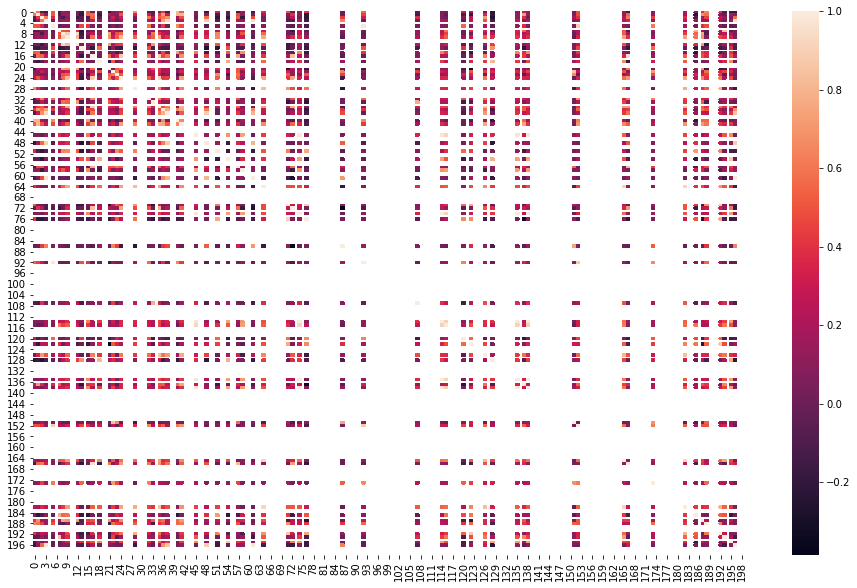

In [30]:
corr2 = corr[:200, :200]
plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

### 위에서 구한 상관계수를 이용해서 특정 앱과 상관계수가 높은 앱 상위 5개를 추출함

In [31]:
app_title = review_matrix_df.index
app_title_list = list(app_title) # 앱 전체 목록
coffey_hands = app_title_list.index(nowApp) # 해당 앱의 인덱스
coffey_hands

3066

In [32]:
corr_coffey_hands = corr[coffey_hands] # 특정 앱과 다른 앱들의 상관계수를 추출
coffey_hands_df = pd.DataFrame(data=corr_coffey_hands, index=app_title, columns=['corr']) # 앱과 상관계수를 맵핑
recommend = coffey_hands_df.loc[coffey_hands_df['corr'] >= 0.9]  # 상관계수가 0.9 이상인 영화를 추출
recommend_latent_review = recommend.sort_values(by='corr', ascending=False)[1:6] # 상관계수로 정렬 후 상위 5개 앱만 추출
recommend_latent_review

,corr
app_id,
89d929e1-8d59-4848-9efd-0fee80c6c743,0.974987
acbea8db-14cf-4aaa-be19-8f933d5a9071,0.963608
a94113b3-cc42-4dbb-a6c2-ed00e10b6a51,0.963129
9fdadfee-3b70-4051-886f-01420ba95c7e,0.962290
b50f3f14-3351-4f46-8667-93fe7fdacdd9,0.958152


### 아이템으로 추천된 5개 앱과 잠재요인으로 추천된 앱 5개를 합쳐서 사용자에게 총 10개의 앱을 추천

In [33]:
result_review = pd.concat([recommend_review, recommend_latent_review.reset_index()], axis=0).reset_index(drop=True)
result_review['app_id']

0    09f67746-a0aa-4bce-a59f-01a896271a75
1    8df5cb8a-cb70-4d35-a538-e689694bfdb0
2    3ee7c943-b0a1-41c1-899a-40426a6e11f4
3    18e1caa4-3513-4962-a69b-7f5768fc697f
4    cfae7502-a7ab-46de-ab94-7f64e8e06f31
5    89d929e1-8d59-4848-9efd-0fee80c6c743
6    acbea8db-14cf-4aaa-be19-8f933d5a9071
7    a94113b3-cc42-4dbb-a6c2-ed00e10b6a51
8    9fdadfee-3b70-4051-886f-01420ba95c7e
9    b50f3f14-3351-4f46-8667-93fe7fdacdd9
Name: app_id, dtype: object